# Airbnb New User Bookings

by Semin Kim. Last Update: 2017/01/07.

(joint with Isaac Solomon from Brown University)

## Variable Description 

- id: user id
- date_account_created: the date of account creation
- timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  date_first_booking because a user can search before signing up
- date_first_booking: date of first booking
- gender
- age
- signup_method
- signup_flow: the page a user came to signup up from
- language: international language preference
- affiliate_channel: what kind of paid marketing
- affiliate_provider: where the marketing is e.g. google, craigslist, other
- first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
- signup_app
- first_device_type
- first_browser
- country_destination: this is the target variable you are to predict

## Summary of the exploratory analysis

- 210K users with 16 features, such as age, gender, account create date, and device used. 
- 87.5% of bookings are US/NDF(no booking). 
- 40% of age are missing and have some outlier having >1000 age.
- Users with missing 'age' information significantly less likely to book.
- Similarly to 'missing age', users with 'missing gender' information significantly less likely to book.
- For users who booked,  
    42% of users booked in a day
    63% of users booked in a week 
    75% of users booked in a month
    82% of users booked in 3 months
    since they joined. 

# 1. Explore User Information

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def plot_cat_cat(df, col1, col2):
    df.groupby([col1, col2]).size().unstack().plot(kind='bar')
    
def plot_cat_cat_percent(df, col1, col2):
    gp = df.groupby([col1, col2]).size().unstack()
    gp.div(gp.sum(1), axis=0).plot(kind='bar', stacked=True)

In [3]:
df = pd.read_csv('train_users_2.csv')

In [4]:
df.shape

(213451, 16)

In [5]:
df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [6]:
df.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## country of destination (booking)

In [8]:
dest_cnt = df['country_destination'].value_counts()
dest_cnt_percent = dest_cnt/(dest_cnt.sum())*100
dest_cnt_percent

NDF      58.347349
US       29.222632
other     4.728954
FR        2.353233
IT        1.328174
GB        1.088774
ES        1.053638
CA        0.669006
DE        0.497070
NL        0.356991
AU        0.252517
PT        0.101663
Name: country_destination, dtype: float64

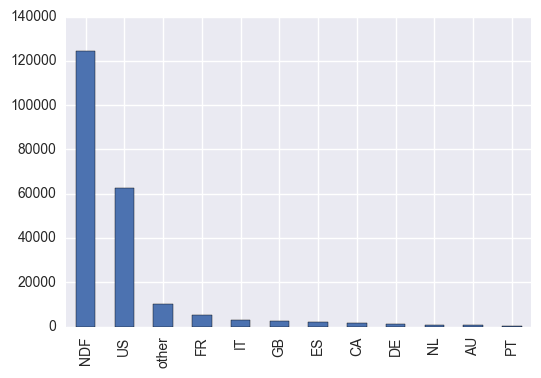

In [9]:
dest_cnt.plot(kind='bar')

- 87.5% of bookings are US/NDF(no booking). 
- We first model US/NDF binary classfication.

In [10]:
df = df[df.country_destination.isin(['NDF', 'US'])]

In [11]:
df.shape

(186919, 16)

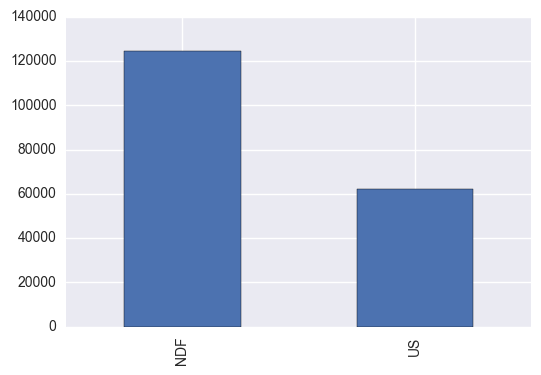

In [12]:
dest_cnt = df.country_destination.value_counts()
dest_cnt.plot(kind='bar')

In [13]:
dest_cnt_percent = dest_cnt/dest_cnt.sum()*100
dest_cnt_percent

NDF    66.629396
US     33.370604
Name: country_destination, dtype: float64

## age

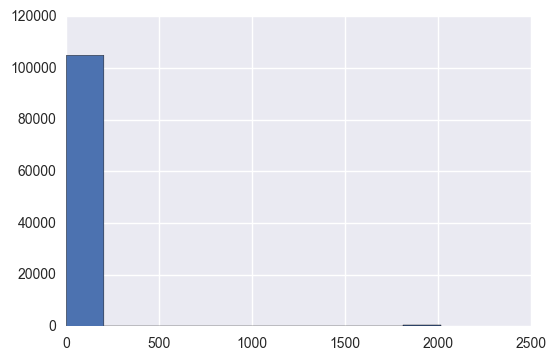

In [14]:
df.age.hist()

- 40% of age are missing. 
- We also see some outliers: age~2000. 

In [15]:
df.age.fillna(1000, inplace=True)
df['ageCat'] = pd.cut(df['age'], 
                        bins=[0,10,20,30,40,50,60,70,80,90,100,10000])

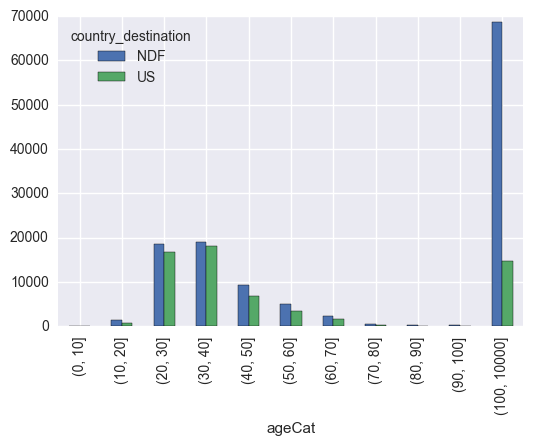

In [16]:
plot_cat_cat(df, 'ageCat', 'country_destination')

# >> Users with 'missing age' much less likely to book.

## gender

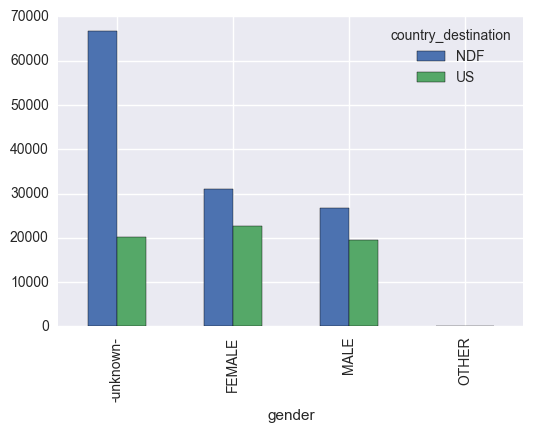

In [17]:
plot_cat_cat(df, 'gender', 'country_destination')

# >> Users with 'missing gender' much less likely to book.

## time to book from creating account. 

In [18]:
def timedelta_to_day(time_delta):
    if pd.notnull(time_delta):
        return time_delta.days
    return np.nan

df['date_account_created'] = pd.to_datetime(df['date_account_created'], format='%Y-%m-%d')
df['date_first_booking'] = pd.to_datetime(df['date_first_booking'], format='%Y-%m-%d')
df['create_year'] = df.date_account_created.apply(lambda x: x.year)
df['create_month'] = df.date_account_created.apply(lambda x: x.month)
df['time_create_to_book'] = (df['date_first_booking']-df['date_account_created']).apply(timedelta_to_day)

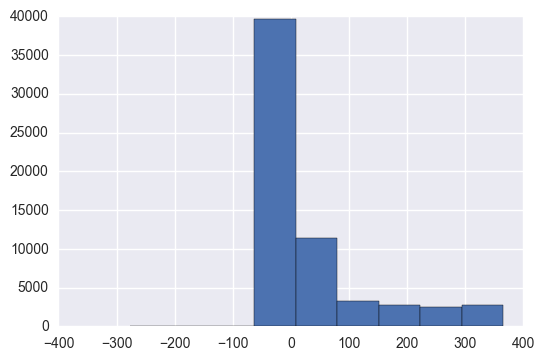

In [19]:
df['time_create_to_book'].hist()

In [20]:
(df.time_create_to_book < 0).sum()

21

- We see some negative value for time_create_to_book.
- Either error or indeed created account after booking. 
- They are only 21 users, so we remove them. 

In [21]:
df.shape

(186919, 20)

In [22]:
df = df[~(df.time_create_to_book < 0)]

In [23]:
df.shape

(186898, 20)

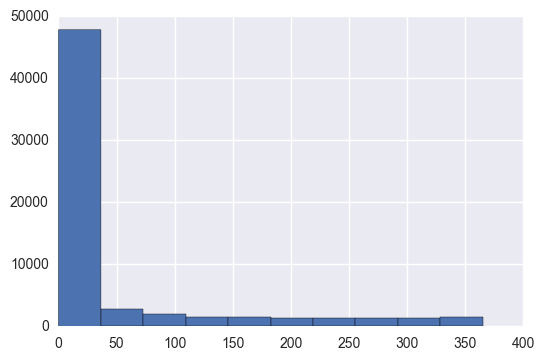

In [24]:
df['time_create_to_book'].hist()

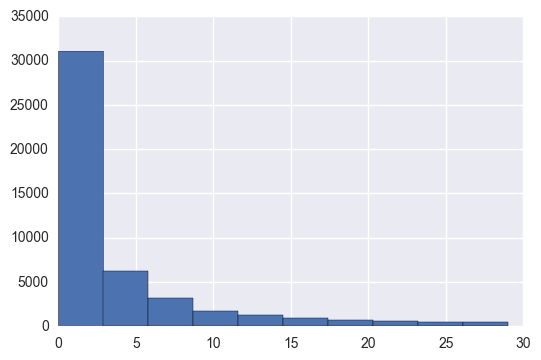

In [25]:
df[df['time_create_to_book'] < 30]['time_create_to_book'].hist()

In [26]:
df[df['time_create_to_book'].notnull()].country_destination.value_counts()

US    62355
Name: country_destination, dtype: int64

In [27]:
df[df['time_create_to_book'].isnull()].country_destination.value_counts()

NDF    124543
Name: country_destination, dtype: int64

- time_create_to_book is well-defined, null for NDF and notnull for US.

In [28]:
df['time_create_to_book_cat'] = pd.cut(df['time_create_to_book'], 
                        bins=[-0.1,1, 7, 30, 90,1000])

In [29]:
time_book_cnt = df['time_create_to_book_cat'].value_counts()
time_book_cnt_percent = time_book_cnt/time_book_cnt.sum()*100
time_book_cnt_percent

(-0.1, 1]     42.432844
(1, 7]        21.175527
(90, 1000]    17.174244
(7, 30]       11.939700
(30, 90]       7.277684
Name: time_create_to_book_cat, dtype: float64

For users who booked,  
- 42% booked in a day.
- 63% booked in a week. 
- 75% booked in a month
- 82% booked in 3 months
since they joined. 

# Other Variables
- signup_method
- signup_flow
- language
- affiliate_channel
- affiliate_provider
- first_affiliate_tracked
- signup_app
- first_device_type
- first_browser

In [30]:
def get_language(s):
    if s == 'en':
        return s
    else:
        return 'not en'

def get_device(s):
    if s in ['Mac Desktop', 'Windows Desktop', 'iPhone', 'iPad']:
        return s.split(' ')[0]
    else:
        return 'Else'

def get_affiliate_provider(s):
    if s in ['direct', 'google']:
        return s
    else:
        return 'other'
    
def get_browser(s):
    if s in ['Chrome', 'Safari', 'Firefox', 'IE', '-unknown-', 
             'Android Browser', 'Mobile Safari', 'Chrome Mobile']:
        return s
    else:
        return 'Else'

In [31]:
df['language'] = df['language'].apply(get_language)
df['first_device_type'] = df['first_device_type'].apply(get_device)
df['affiliate_provider'] = df['affiliate_provider'].apply(get_affiliate_provider)
df['first_browser'] = df['first_browser'].apply(get_browser)

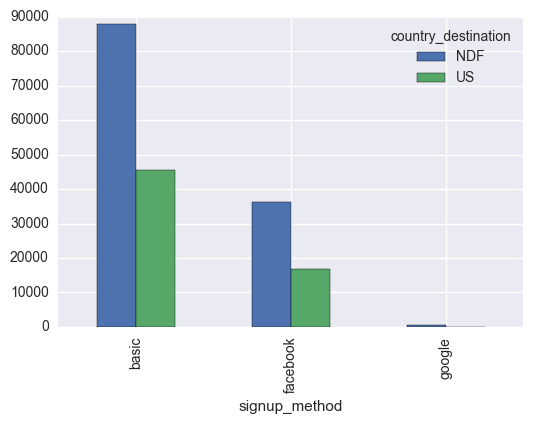

In [32]:
plot_cat_cat(df, 'signup_method', 'country_destination')

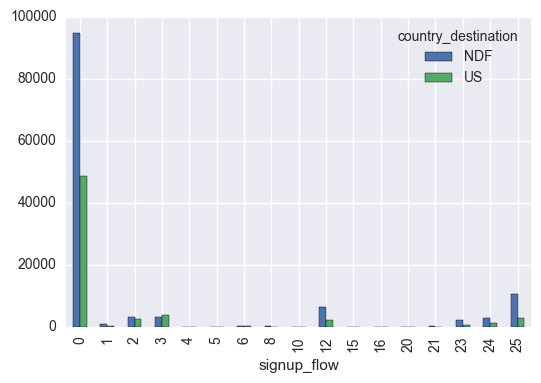

In [33]:
plot_cat_cat(df, 'signup_flow', 'country_destination')

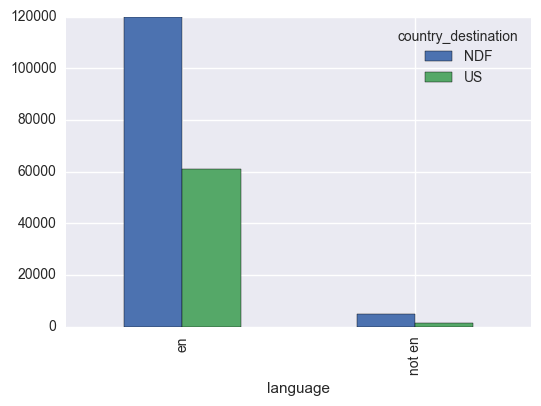

In [34]:
plot_cat_cat(df, 'language', 'country_destination')

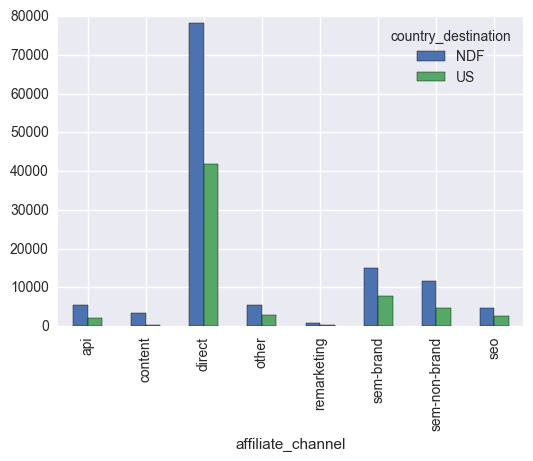

In [35]:
plot_cat_cat(df, 'affiliate_channel', 'country_destination')

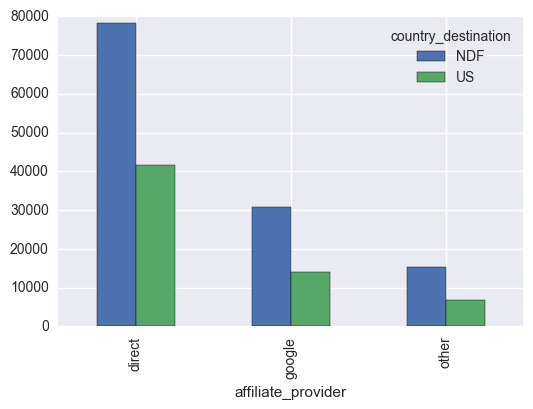

In [36]:
plot_cat_cat(df, 'affiliate_provider', 'country_destination')

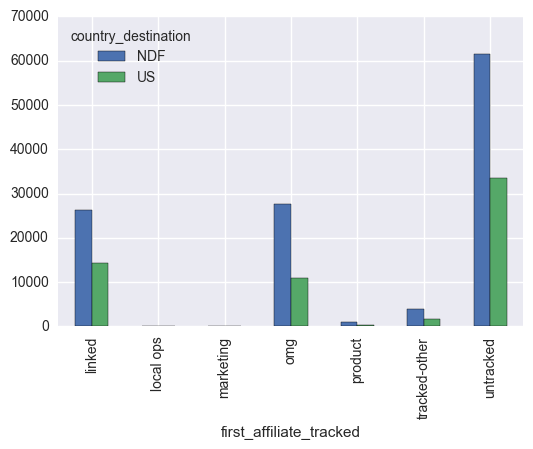

In [37]:
plot_cat_cat(df, 'first_affiliate_tracked', 'country_destination')

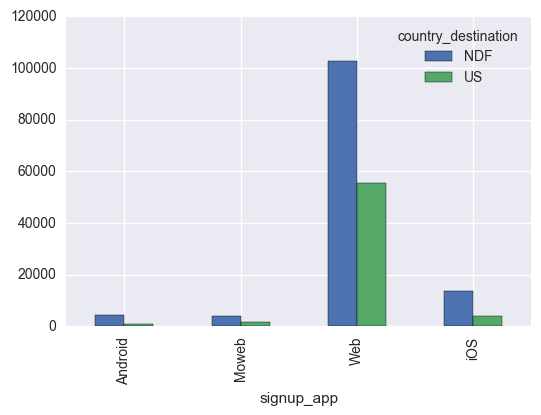

In [38]:
plot_cat_cat(df, 'signup_app', 'country_destination')

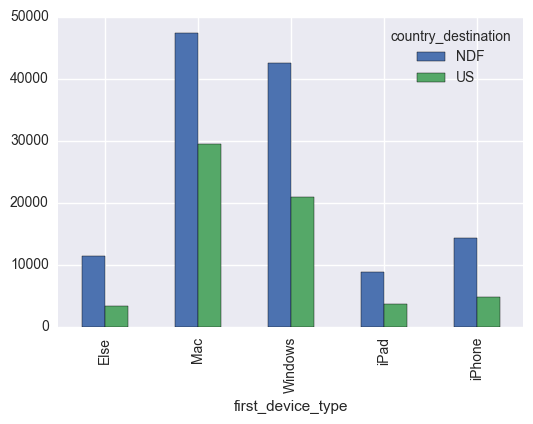

In [39]:
plot_cat_cat(df, 'first_device_type', 'country_destination')

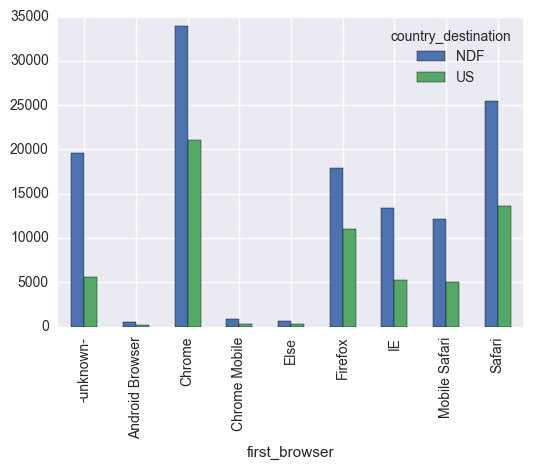

In [40]:
plot_cat_cat(df, 'first_browser', 'country_destination')